In [1]:
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

from rllr.utils.plotting.video import show_video
from rllr.utils.logger import init_logger
from rllr.utils.common import switch_reproducibility_on
from rllr.utils.plotting.display import display_stats

In [3]:
from pyhocon import ConfigFactory

config = ConfigFactory.parse_file('../experiments/conf/minigrid_navigation_mlp_master_worker.hocon')
config['env']['video_path'] = './video/'

In [4]:
switch_reproducibility_on(config['seed'])

# Train worker

In [5]:
from experiments import train_worker
init_logger('experiments.train_worker')

In [6]:
env = train_worker.gen_navigation_env(config['env'])

In [7]:
worker_agent = train_worker.get_agent(config)

2021-04-29 13:01:49,627 INFO    rllr.algo.dqn          : Running on device: cpu


In [8]:
scores, steps = train_worker.run_episodes(env, worker_agent, n_episodes=1000, verbose=100)

2021-04-29 13:03:23,944 INFO    experiments.train_worker   : Episode: 100. scores: -14.68, steps: 154.08, achieved: 0.66
2021-04-29 13:04:25,344 INFO    experiments.train_worker   : Episode: 200. scores: -9.44, steps: 103.45, achieved: 0.82
2021-04-29 13:05:06,313 INFO    experiments.train_worker   : Episode: 300. scores: -5.72, steps: 66.87, achieved: 0.88
2021-04-29 13:05:28,393 INFO    experiments.train_worker   : Episode: 400. scores: -2.52, steps: 35.97, achieved: 0.98
2021-04-29 13:05:53,379 INFO    experiments.train_worker   : Episode: 500. scores: -2.56, steps: 36.41, achieved: 0.98
2021-04-29 13:06:15,591 INFO    experiments.train_worker   : Episode: 600. scores: -2.21, steps: 32.50, achieved: 0.95
2021-04-29 13:06:28,930 INFO    experiments.train_worker   : Episode: 700. scores: -1.24, steps: 23.00, achieved: 0.96
2021-04-29 13:06:37,485 INFO    experiments.train_worker   : Episode: 800. scores: -0.38, steps: 14.70, achieved: 0.99
2021-04-29 13:06:44,465 INFO    experiments.t

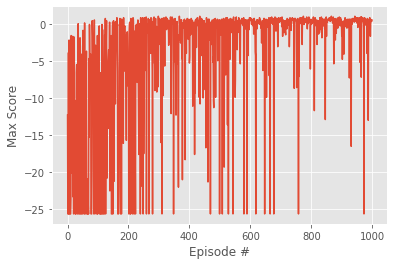

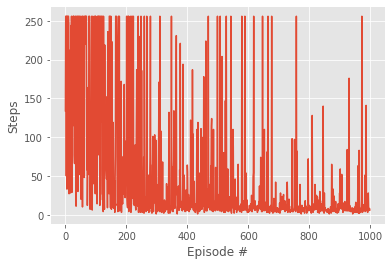

In [9]:
display_stats(scores, steps)

# Train master

In [10]:
from experiments import train_master
init_logger('experiments.train_master')

In [11]:
config = ConfigFactory.parse_file('../experiments/conf/minigrid_navigation_mlp_master_worker.hocon')
del config['env']['goal_achieving_criterion']
del config['env']['goal_type']

In [12]:
emb_size = worker_agent.qnetwork_local.state_encoder.goal_state_encoder.output_size
master_agent = train_master.get_master_agent(emb_size, config)
worker_agent.explore = False

In [13]:
env = train_worker.gen_env(config['env'])

In [ ]:
scores, steps = train_master.run_episodes(env, worker_agent, master_agent, n_episodes=1000, verbose=100)

2021-04-29 13:12:32,417 INFO    experiments.train_master   : Episode: 100. scores: 0.00, steps: 256.00
2021-04-29 13:18:14,308 INFO    experiments.train_master   : Episode: 200. scores: 0.00, steps: 256.00
2021-04-29 13:24:01,765 INFO    experiments.train_master   : Episode: 300. scores: 0.00, steps: 256.00
2021-04-29 13:30:01,727 INFO    experiments.train_master   : Episode: 400. scores: 0.00, steps: 256.00


In [ ]:
display_stats(scores, steps)